In [138]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [139]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
import geopandas as gpd
if manual:
    %matplotlib inline

In [140]:
training_folder = '../../'
plot_path = training_folder + 'outputs/plot/'

In [141]:
distribution = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/distribution'.format(scen=scenario))
pt = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/pruning_pt_pathfinder'.format(scen=scenario))
car = stepmodel.read_zippedpickles(training_folder + r'model/{scen}/constrained_road_pathfinder'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 17.90it/s]


In [142]:
sm = pt.copy()
sm.car_los = car.car_los
sm.volumes = distribution.volumes
# each segment will be processed independently in the logit
sm.segments = ['car_owner', 'pt_captive'] 

In [143]:
sm.analysis_pt_los(walk_on_road=True)

path_analysis: 100%|███████████████████████████████████████████████████████████| 51338/51338 [00:08<00:00, 6188.13it/s]


In [144]:
sm.analysis_pt_time(walk_on_road=False)


In [145]:
# the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario,
                               )

var.head()

category               parameter        
general                parent               base
                       bus_speed_factor      0.8
                       boarding_cost_acf     300
                       boarding_cost_wor     300
preparation_footpaths  max_length           3000
Name: base, dtype: object

In [146]:
kwargs = var['preparation_logit'].to_dict()

# Parameters conversion
kwargs

{'time': -0.00055,
 'price': -1,
 'transfers': -0.25,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1}

# LOGIT SCALES

In [147]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [148]:
sm.utility_values.T

value,time,price,ntransfers,mode_utility
segment,,,,
root,-0.00055,-1.0,-0.25,1.0
car_owner,-0.00055,-1.0,-0.25,1.0
pt_captive,-0.00055,-1.0,-0.25,1.0


In [149]:
sm.logit_scales.T # phi

route_type,car,tram,rail,subway,bus,walk,root,pt
segment,,,,,,,,
root,0.0,0.1,0.1,0.1,0.1,0.0,1.0,0.5
car_owner,0.0,0.1,0.1,0.1,0.1,0.0,1.0,0.5
pt_captive,0.0,0.1,0.1,0.1,0.1,0.0,1.0,0.5


In [150]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100 # PT captive can not use the car
sm.mode_utility.T

route_type,car,tram,rail,subway,bus,walk,root
segment,,,,,,,
root,0,0,0,0,0,0,0
car_owner,0,0,0,0,0,0,0
pt_captive,-100,0,0,0,0,0,0


In [151]:
sm.mode_nests.T # nested structure can be set for each segment

route_type,car,tram,rail,subway,bus,walk,root,pt
segment,,,,,,,,
root,root,pt,pt,pt,pt,root,NaN,root
car_owner,root,pt,pt,pt,pt,root,NaN,root
pt_captive,root,pt,pt,pt,pt,root,NaN,root


# UTILITY EVALUATION
## add relevant columns to path dataframes

In [152]:
for segment in sm.segments:
    segment_utility = var.loc[(segment,sm.mode_utility.index)].droplevel(level=0)
    sm.mode_utility.loc[segment_utility.index,segment] = segment_utility.to_list()
    
sm.mode_utility = sm.mode_utility.fillna(0)
sm.mode_utility = sm.mode_utility*60*sm.utility_values.loc['time']

print(sm.mode_utility)

segment     root  car_owner  pt_captive
route_type                             
car         -0.0    -0.3300     -0.0000
tram        -0.0    -0.0000     -0.0000
rail        -0.0    -0.1485     -0.0165
subway      -0.0    -0.0330     -0.0495
bus         -0.0    -0.3960     -0.0495
walk        -0.0    -0.0000     -0.0000
root        -0.0    -0.0000     -0.0000


In [153]:

sm.pt_los['price'] = 0 # sm.analysis_pt_fare
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

In [154]:
sm.pt_los

,origin,destination,gtime,path,pathfinder_session,reversed,route_id_set,route_type_set,broken_column,broken_route_type,...,all_walk,ntransfers,time_link_path,length_link_path,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,price
0,zone_0,zone_0,-1.000000e+09,"(zone_0,)",best_path,False,{},{},NaN,NaN,...,True,0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0
1,zone_0,zone_1,8.629405e+02,"(zone_0, 250, link_4302, 94, zone_1)",best_path,False,{1},{subway},NaN,NaN,...,False,0,60.0,NaN,750.940549,0.0,60.0,52.0,0,0
2,zone_0,zone_10,1.500011e+03,"(zone_0, 250, link_3654, link_3655, link_3656,...",best_path,False,"{95, 4}","{subway, bus}",NaN,NaN,...,False,1,360.0,NaN,923.011022,0.0,360.0,217.0,0,0
3,zone_0,zone_100,1.974725e+03,"(zone_0, 250, link_4302, link_4303, link_4304,...",best_path,False,"{7B, 1}","{rail, subway}",NaN,NaN,...,False,4,660.0,NaN,919.725142,0.0,660.0,395.0,0,0
4,zone_0,zone_101,2.319297e+03,"(zone_0, 250, link_4302, link_4303, link_4304,...",best_path,False,"{5, 1}","{rail, subway}",NaN,NaN,...,False,3,780.0,NaN,1269.796714,0.0,780.0,269.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,zone_90,zone_96,2.302753e+03,"(zone_90, 235, link_4997, link_4998, 74, link_...",route_breaker,True,NaN,NaN,route_id,NaN,...,False,3,780.0,NaN,1084.752695,0.0,780.0,438.0,0,0
185,zone_91,zone_96,1.668034e+03,"(zone_91, 69, link_5006, 23, link_4385, link_4...",route_breaker,True,NaN,NaN,route_id,NaN,...,False,3,720.0,NaN,502.533745,0.0,720.0,445.5,0,0
186,zone_92,zone_96,2.032721e+03,"(zone_92, 41, link_4507, link_4508, link_4509,...",route_breaker,True,NaN,NaN,route_id,NaN,...,False,2,780.0,NaN,879.721120,0.0,780.0,373.0,0,0
187,zone_93,zone_96,1.942786e+03,"(zone_93, 30, link_805, link_806, 278, link_43...",route_breaker,True,NaN,NaN,route_id,NaN,...,False,3,480.0,NaN,953.285640,0.0,480.0,509.5,0,0


## calculate utility

In [155]:
#on à plus le detail dans le car_los semble il

In [156]:
sm.analysis_pt_route_type(hierarchy=[ 'car','rail', 'subway', 'tram', 'bus', 'walk'])
sm.analysis_car_route_type() # add route_type = 'car' in car_los

# concatenate pt_los and car_los
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p))
sm.analysis_mode_utility(how=var['analysis_mode_utility']['how'])

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.24it/s]


## calulate the utilities and the probabilities

In [157]:
sm.step_logit(n_paths_max=10, workers=1, nchunks=10)

sm.compute_los_volume()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]


In [158]:
sm.step_assignment(
        road=False, 
        boardings=True, 
        alightings=True, 
        transfers=True,
        segmented=False,
        boarding_links=True,
        alighting_links=True)

# ASSIGNMENT

In [159]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']
sm.step_assignment(
    road=True,
    boardings=True,
    boarding_links=True,
    alightings=True,
    alighting_links=True,
    transfers=True,
)

In [160]:
sm.los["in_vehicle_length"] = 0
sm.los["length"] = 0

In [161]:
sm.nodes = gpd.GeoDataFrame(sm.nodes)

In [178]:
sm.links_export = sm.links[['index', 'a', 'trip_id', 'link_sequence', 'departure_time',
       'pickup_type', 'b', 'arrival_time', 'drop_off_type', 'time', 'headway',"geometry"]]

# GEOJSON EXPORT

In [179]:
if manual:
    sm.to_json(training_folder + 'json', only_attributes=['nodes','links_export'])

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 47/47 [00:02<00:00, 21.36it/s]


# XLSX EXPORT

In [167]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
#sm.summary_od(inplace=True)

#sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [168]:
sm.to_excel(training_folder + r'model/%s/stacks.xlsx'%scenario, prefix='stack')

# ZIP EXPORT

In [169]:
sm.to_zippedpickles(training_folder + 'model/{scen}/logit'.format(scen=scenario), omitted_attributes=['los'])

stack_aggregated_link_max: 100%|███████████████████████████████████████████████████████| 46/46 [00:10<00:00,  4.52it/s]


# PLOT

In [170]:
import numpy as np
paths = sm.pt_los
link_routes = sm.links['route_short_name'].to_dict()
def link_path_to_routes(link_path):
    routes = [link_routes[l] for l in link_path]
    used = set()
    rsn = []
    for route in routes:
        if route not in used:
            rsn.append(route)
        used.add(route)
    return rsn

paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
paths['ntransfers'] = paths['transfers'].apply(len)

def title(paths):
    paths['min'] = np.round(paths['time'] / 60).astype(int)
    mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
    title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
    title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
    title += ' | '+  paths['min'].astype(str) + ' mins | '
    title += paths['route_path'].apply(lambda l: '—>'.join(l) )
    title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
    title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
    return title


paths['title'] = title(paths)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.21s/it]


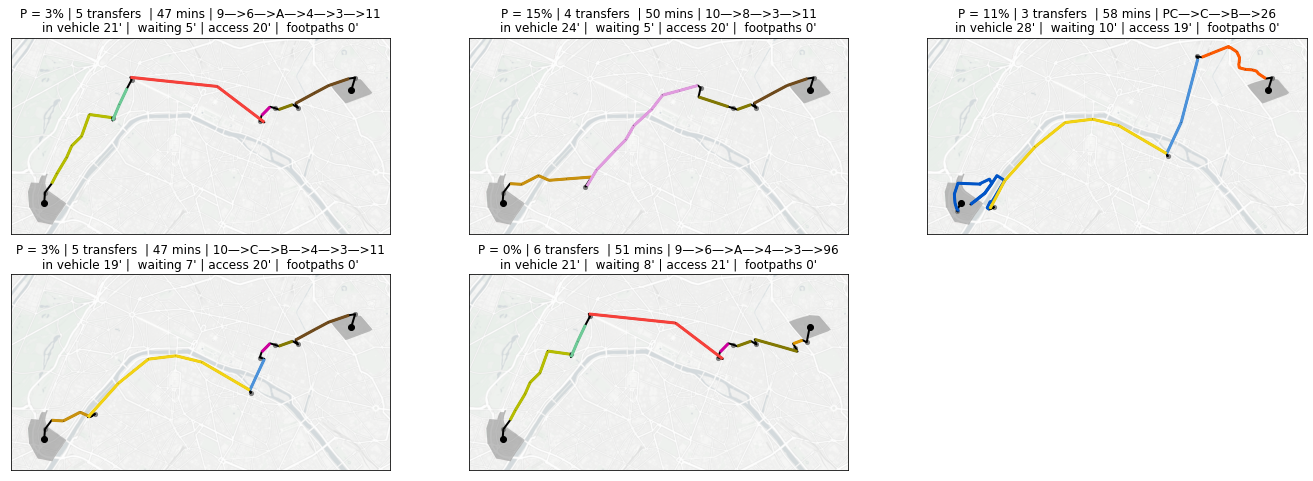

In [171]:
if manual:
    origin, destination='zone_74',  'zone_105'
    n =  len(sm.pt_los.set_index(['origin', 'destination']).loc[(origin, destination)])

    rows = 2
    if n > 6:
        rows = 3
    if n > 12:
        rows = 4

    columns = n // rows + bool(n%rows)


    url = 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'
    fig, axes = sm.plot_separated_paths(
        origin, destination, rows=rows, figsize=[20, 20],
        title='title', constrained_layout=True,
        basemap_url=url, zoom=13
    )
    ax = fig.get_axes()[0]
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
    fig.constrained_layout = True

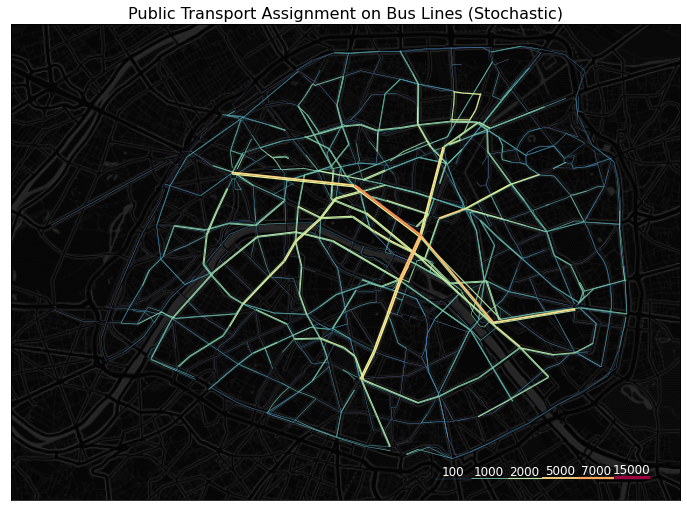

In [172]:
if manual:
    from syspy.syspy_utils import data_visualization as dv
    bandwidth = dv.bandwidth
    power=0.5
    lv = [100, 1000, 2000, 5000, 7000, 15000]
    url = 'http://a.basemaps.cartocdn.com/dark_nolabels/{z}/{x}/{y}.png'

    sm.road_links['volume'] = sm.road_links[('volume', 'pt')]
    i_links = sm.links.loc[sm.links.road_length.isnull()]
    df = pd.concat([i_links, sm.road_links])
    df = df.loc[df['volume'] > 0]

    plot= bandwidth(
        df, value_column='volume', power=power, figsize=[12, 12], legend_values=lv,
        label_kwargs={'color':'white', 'fontsize':12}
    )
    dv.add_basemap(plot, url=url, zoom=12)
    plot.set_title('Public Transport Assignment on Bus Lines (Stochastic)', fontsize=16)